In [1]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import math

import utils as u
u.widen_ipython_window()

In [2]:
# Paths

MAIN_PATH = "/home/mahesh/Desktop/ML/kaggle/amex/"

# Data
PATH_TO_DATA                = MAIN_PATH + "data/"
PATH_TO_PROCESSED2_DATA     = PATH_TO_DATA + "processed2/"
PATH_TO_PROCESSED4_DATA     = PATH_TO_DATA + "processed4/"
PATH_TO_PROCESSED3_DATA     = PATH_TO_DATA + "processed3/"

FILENAME_TRAIN_PROCESSED2_DATA_CAT_NOCHANGE_FEATHER   = PATH_TO_PROCESSED2_DATA + "train_data_cat_nochange.f"
FILENAME_TRAIN_PROCESSED2_LABELS_FEATHER = PATH_TO_PROCESSED2_DATA + "train_labels.f"

FILENAME_TEST_PROCESSED2_DATA_FEATHER    = PATH_TO_PROCESSED2_DATA + "test_data.f"

#FILENAME_TRAIN_PROCESSED3_DATA_PARAQUET       = PATH_TO_PROCESSED3_DATA + "train_data.pq"
#FILENAME_TRAIN_PROCESSED4_FE_DATA_RNN_FEATHER = PATH_TO_PROCESSED4_DATA + "train_FE_data_RNN.f"

# Models
PATH_TO_MODEL   = MAIN_PATH + "models/"

In [3]:
u.pt("Reading training data.")
train_full_data   = pd.read_feather(FILENAME_TRAIN_PROCESSED2_DATA_CAT_NOCHANGE_FEATHER)
train_full_labels = pd.read_feather(FILENAME_TRAIN_PROCESSED2_LABELS_FEATHER)
u.pt("Completed reading training data.")


2022-08-26 17:56:45.777669 : Reading training data.
2022-08-26 17:56:48.810772 : Completed reading training data.


Number of rows per cid below
1 : 5120, 2 : 6098, 3 : 5778, 4 : 4673, 5 : 4671, 6 : 5515, 7 : 5198, 8 : 6110, 9 : 6411
10 : 6721, 11 : 5961, 12 : 10623, 13 : 386034

total rows:5531451

total cids:458913


If we add zeroed out rows to have 13 rows per cid, then we will add (458913 \* 13 - 5531415 = 434418 rows) which is about 7% additional rows that are all zeroed out.

Iterate over the rows and collect some stats on the columns (max, min value), in the case of enums we'll collect the data in a set.

In [4]:
id_time_cols = set(['customer_ID', 'S_2'])
cat_cols = set(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'])


def process_cat_col(chunk, col_stats, col):
    vals = chunk[col].astype("category").cat.categories.values.tolist()
    n_null_count = chunk[col].isnull().sum()
    if col in col_stats:
        (c_cat_vals, c_null_count) = col_stats[col]
        col_stats[col] = (c_cat_vals.union(set(vals)), c_null_count + n_null_count)
    else:
        col_stats[col] = (set(vals), n_null_count)
    
def process_real_col( chunk, col_stats, col):
    n_min = chunk[col].min()
    n_max = chunk[col].max()
    n_mean = chunk[col].mean()
    n_median = chunk[col].median()
    n_nan_count = chunk[col].isnull().sum()
    if col in col_stats:
        ((c_min, c_max), c_nan_count) = col_stats[col]
        if (c_min < n_min):
            n_min = c_min
        if (c_max > n_max):
            n_max = c_max
        col_stats[col] = ((n_min, n_max, n_mean, n_median), c_nan_count + n_nan_count)
    else:
        col_stats[col] = ((n_min, n_max, n_mean, n_median), n_nan_count)

def process_chunk(chunk, col_stats):
    columns = list(chunk)
    for col in columns:
        if col not in id_time_cols:
            if col in cat_cols:
                process_cat_col(chunk, col_stats, col)
            else:
                process_real_col(chunk, col_stats, col)
            
chunksize = 100000
col_stats = {}

process_chunk(train_full_data, col_stats)

In [7]:
TOTAL_ROWS = 5531451

null_percs = []

null_bins = {}

for col in col_stats:
    null_perc = (col_stats[col][1]/TOTAL_ROWS)*100
    if (null_perc != 0):
        #bin = (math.floor(null_perc/10)
        bin = (math.floor(null_perc))
        if bin in null_bins:
            null_bins[bin].append(col)
        else:
            null_bins[bin] = [col]
    if col in cat_cols:
        print (f'{col} values are {col_stats[col][0]}, null values are {null_perc}')
    else:
        print (f'{col} min, max, mean, median is {col_stats[col][0]}, null values are {null_perc}')
    null_percs.append(null_perc)

P_2 min, max, mean, median is (-0.45895484, 1.01, 0.6563343, 0.694295), null values are 0.8313370216964772
D_39 min, max, mean, median is (5.02619e-09, 5.3896194, 0.15311716, 0.009056902), null values are 0.0
B_1 min, max, mean, median is (-7.588799, 1.3240604, 0.124010056, 0.031329677), null values are 0.0
B_2 min, max, mean, median is (9.19228e-09, 1.01, 0.621489, 0.81433284), null values are 0.0364461332117016
R_1 min, max, mean, median is (1.534223e-09, 3.2562845, 0.078802735, 0.0057822303), null values are 0.0
S_3 min, max, mean, median is (-0.62713206, 5.482888, 0.22584538, 0.1639082), null values are 18.44984254583472
D_41 min, max, mean, median is (5.566545e-10, 8.988807, 0.059784725, 0.0057467255), null values are 0.0364461332117016
B_3 min, max, mean, median is (6.285293e-09, 1.6252623, 0.13253897, 0.009777229), null values are 0.0364461332117016
D_42 min, max, mean, median is (-0.00045433026, 4.1911187, 0.18497436, 0.120518774), null values are 85.69427804747795
D_43 min, ma

In [14]:
for col in cat_cols:
    print (f'{col} values are {col_stats[col][0]}, null values are {null_perc}')

D_64 values are {'-1', 'U', 'O', 'R'}, null values are 1.8358293330267232
D_114 values are {0.0, 1.0}, null values are 1.8358293330267232
D_126 values are {0.0, 1.0, -1.0}, null values are 1.8358293330267232
D_117 values are {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, -1.0}, null values are 1.8358293330267232
D_66 values are {0.0, 1.0}, null values are 1.8358293330267232
D_63 values are {'CL', 'CO', 'XL', 'XM', 'CR', 'XZ'}, null values are 1.8358293330267232
D_116 values are {0.0, 1.0}, null values are 1.8358293330267232
B_38 values are {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}, null values are 1.8358293330267232
B_30 values are {0.0, 1.0, 2.0}, null values are 1.8358293330267232
D_68 values are {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0}, null values are 1.8358293330267232
D_120 values are {0.0, 1.0}, null values are 1.8358293330267232


In [42]:

train = train_full_data.loc[:1000].copy()


TEMP = 1

if TEMP:
    # REDUCE STRING COLUMNS 
    # from 64 bytes to 8 bytes, and 10 bytes to 3 bytes respectively
    train['year'] = (train.S_2.dt.year-2000).astype('int8')
    train['month'] = (train.S_2.dt.month).astype('int8')
    train['day'] = (train.S_2.dt.day).astype('int8')
    del train['S_2']
        
    # LABEL ENCODE CAT COLUMNS (and reduce to 1 byte)
    # with 0: padding, 1: nan, 2,3,4,etc: values
    d_63_map = {'CL':1, 'CO':2, 'CR':3, 'XL':4, 'XM':5, 'XZ':6}
    train['D_63'] = train.D_63.map(d_63_map).fillna(0).astype('int8')

    d_64_map = {'-1':1,'O':2, 'R':3, 'U':4}
    train['D_64'] = train.D_64.map(d_64_map).fillna(0).astype('int8')
    
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
    OFFSETS = [1,0,1,1,2,1,2,1,1] #2 minus minimal value in full train csv
    # then 0 will be padding, 1 will be NAN, 2,3,4,etc will be values
    for c,s in zip(CATS,OFFSETS):
        train[c] = train[c] + s
        train[c] = train[c].fillna(0).astype('int8')
    CATS += ['D_63','D_64']
    
    # ADD NEW FEATURES HERE
    # EXAMPLE: train['feature_189'] = etc etc etc
    # EXAMPLE: train['feature_190'] = etc etc etc
    # IF CATEGORICAL, THEN ADD TO CATS WITH: CATS += ['feaure_190'] etc etc etc
    
    # REDUCE MEMORY DTYPE
    SKIP = ['customer_ID','year','month','day']
    for c in train.columns:
        if c in SKIP: continue
        if str( train[c].dtype )=='int64':
            train[c] = train[c].astype('int32')
        if str( train[c].dtype )=='float64':
            train[c] = train[c].astype('float32')

    # For numerical features that have NaNs add as extra column that indicates if 
    # the value is not-nan (1) or nan
    
    zeros = np.zeros((train.shape[0],), dtype='int8')
    ones = np.ones((train.shape[0],), dtype='int8')
    
    for c in train.columns:
        if ((c in SKIP) or (c in CATS)): continue
        c_exists = c + "_exists"
        train[c_exists] = np.where(np.invert(np.isnan(train[c].values)), ones, zeros)
        train[c] = train[c].fillna(0)

    tmp = train[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
    more = np.array([],dtype='int64') 
    for j in range(1,13):
        i = tmp.loc[tmp==j].index.values
        #print(i)
        more = np.concatenate([more,np.repeat(i,13-j)])
        #print(more)
    df = train.iloc[:len(more)].copy().fillna(0)
    df = df * 0
    # df = df * 0 - 1 #pad numerical columns with -1
    df[CATS] = df[CATS].astype('int8') #pad categorical columns with 0
    df['customer_ID'] = more
    train = pd.concat([train,df],axis=0,ignore_index=True)
    print(train)

              customer_ID       P_2      D_39       B_1       B_2       R_1  \
0    -4532153018459703766  0.938469  0.001733  0.008724  1.006838  0.009228   
1    -4532153018459703766  0.936665  0.005775  0.004923  1.000653  0.006151   
2    -4532153018459703766  0.954180  0.091505  0.021655  1.009672  0.006815   
3    -4532153018459703766  0.960384  0.002455  0.013683  1.002700  0.001373   
4    -4532153018459703766  0.947248  0.002483  0.015193  1.000727  0.007605   
...                   ...       ...       ...       ...       ...       ...   
1074  3797339109041209175  0.000000  0.000000  0.000000  0.000000  0.000000   
1075  6091447297340677300  0.000000  0.000000  0.000000  0.000000  0.000000   
1076  6091447297340677300  0.000000  0.000000  0.000000  0.000000  0.000000   
1077  6091447297340677300  0.000000  0.000000  0.000000  0.000000  0.000000   
1078 -3142143704880810245  0.000000  0.000000  0.000000  0.000000  0.000000   

           S_3      D_41       B_3  D_42  ...  D_13

In [43]:
train[['D_42','D_42_exists']]

,D_42,D_42_exists
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
1074,0.0,0
1075,0.0,0
1076,0.0,0
1077,0.0,0


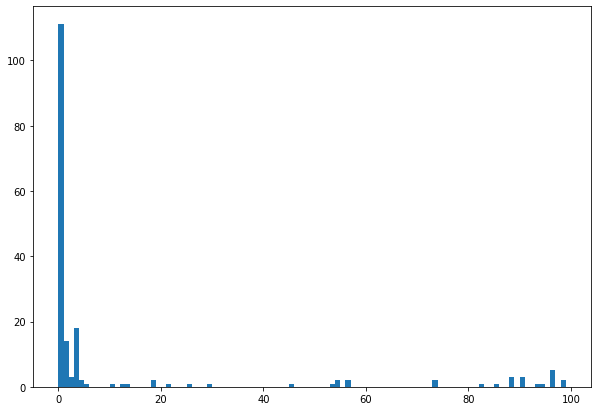

In [6]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(null_percs, bins = range(0,100,1))
 
# Show plot
plt.show()

In [8]:
for k in sorted(null_bins.keys()):
    count = len(null_bins[k])
    print(f'{k} : {count}')
#     if k == 0 : continue
#     for col in null_bins[k]:
#         null_perc = round((col_stats[col][1]/TOTAL_ROWS)*100,2)
#         if col in cat_cols:
#             print (f'{col} values are {col_stats[col][0]}, null values are {null_perc}%')
#         else:
#             print (f'{col} min, max, mean, median is {col_stats[col][0]}, null values are {null_perc}%')

0 : 45
1 : 14
2 : 3
3 : 18
4 : 2
5 : 1
10 : 1
12 : 1
13 : 1
18 : 2
21 : 1
25 : 1
29 : 1
45 : 1
53 : 1
54 : 2
56 : 2
73 : 2
82 : 1
85 : 1
88 : 3
90 : 3
93 : 1
94 : 1
96 : 5
98 : 2
99 : 6


In [39]:
train_full_data.describe()

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5.531451e+06,5.485466e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.531451e+06,4.510907e+06,5.529435e+06,5.529435e+06,791314.000000,...,1.946990e+05,1.946990e+05,1.946990e+05,5.429903e+06,5.490819e+06,5.429903e+06,944408.000000,5.429903e+06,5.490724e+06,5.429903e+06
mean,-4.089913e+15,6.563343e-01,1.531172e-01,1.240101e-01,6.214890e-01,7.880273e-02,2.258454e-01,5.978473e-02,1.325390e-01,0.184974,...,2.427725e-01,1.424409e-02,1.646184e-01,1.789304e-01,2.664348e-02,1.645212e-01,0.390799,1.788023e-01,5.238953e-02,6.233494e-02
std,5.328359e+18,2.446494e-01,2.700709e-01,2.119869e-01,4.014876e-01,2.263971e-01,1.933475e-01,2.025443e-01,2.349929e-01,0.228185,...,2.101320e-01,9.571116e-02,2.670208e-01,3.790614e-01,1.455480e-01,3.482771e-01,0.236182,3.789498e-01,1.825135e-01,1.934937e-01
min,-9.223358e+18,-4.589548e-01,5.026190e-09,-7.588799e+00,9.192280e-09,1.534223e-09,-6.271321e-01,5.566545e-10,6.285293e-09,-0.000454,...,6.316773e-08,1.078787e-08,3.307923e-08,3.767347e-10,3.725073e-09,1.650100e-10,-0.014539,5.549692e-09,2.500991e-09,1.226024e-09
25%,-4.620523e+18,4.803307e-01,4.528464e-03,8.863645e-03,1.053313e-01,2.895934e-03,1.272588e-01,2.873244e-03,5.227570e-03,0.037516,...,9.314305e-03,2.532470e-03,3.517452e-03,3.027212e-03,2.555848e-03,3.026087e-03,0.199399,3.028116e-03,2.752895e-03,3.028347e-03
50%,1.608208e+14,6.942950e-01,9.056902e-03,3.132968e-02,8.143328e-01,5.782230e-03,1.639082e-01,5.746725e-03,9.777229e-03,0.120519,...,2.539468e-01,5.069830e-03,7.037814e-03,6.053010e-03,5.110523e-03,6.051590e-03,0.382136,6.053151e-03,5.508129e-03,6.053247e-03
75%,4.611787e+18,8.648159e-01,2.366407e-01,1.259019e-01,1.002403e+00,8.660590e-03,2.581017e-01,8.615665e-03,1.550507e-01,0.250869,...,2.582450e-01,7.573434e-03,5.015469e-01,9.080455e-03,7.663697e-03,9.078914e-03,0.559307,9.076287e-03,8.260448e-03,9.080930e-03
max,9.223350e+18,1.010000e+00,5.389619e+00,1.324060e+00,1.010000e+00,3.256284e+00,5.482888e+00,8.988807e+00,1.625262e+00,4.191119,...,1.759910e+00,1.009998e+00,3.005383e+00,1.010000e+00,1.010000e+00,1.339910e+00,2.229368,1.010000e+00,1.343331e+00,4.827630e+00


In [52]:
train = (train_full_data.loc[0:25])[["customer_ID","S_2"]]
targets = train_full_labels.loc[(train_full_labels.customer_ID.isin(train.customer_ID.values))]
#train['year'] = (train.S_2.dt.year-2000).astype('int8')
train['month'] = (train.S_2.dt.month).astype('int8')
#train['day'] = (train.S_2.dt.day).astype('int8')

print(train)
print(targets)

            customer_ID        S_2  month
0  -4532153018459703766 2017-03-09      3
1  -4532153018459703766 2017-04-07      4
2  -4532153018459703766 2017-05-28      5
3  -4532153018459703766 2017-06-13      6
4  -4532153018459703766 2017-07-16      7
5  -4532153018459703766 2017-08-04      8
6  -4532153018459703766 2017-09-18      9
7  -4532153018459703766 2017-10-08     10
8  -4532153018459703766 2017-11-20     11
9  -4532153018459703766 2017-12-04     12
10 -4532153018459703766 2018-01-11      1
11 -4532153018459703766 2018-02-21      2
12 -4532153018459703766 2018-03-13      3
13 -6696652885210834715 2017-03-01      3
14 -6696652885210834715 2017-04-16      4
15 -6696652885210834715 2017-05-07      5
16 -6696652885210834715 2017-06-25      6
17 -6696652885210834715 2017-07-30      7
18 -6696652885210834715 2017-08-19      8
19 -6696652885210834715 2017-09-15      9
20 -6696652885210834715 2017-10-20     10
21 -6696652885210834715 2017-11-24     11
22 -6696652885210834715 2017-12-29

In [4]:
test_df = pd.read_feather(FILENAME_TEST_PROCESSED2_DATA_FEATHER)

In [9]:
test_df["D_87"].describe()
test_df["D_87"].isna().sum()

11352790

In [10]:
test_df["B_30"].describe()

count     11360845.0
unique           3.0
top              0.0
freq       9618034.0
Name: B_30, dtype: float64